In [494]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [604]:
# Traffic Simulation

class LoadGenerator:
    """
    Generate load patterns with added Gaussian noise.
    """
    def __init__(self, mean=0, std=1, seed=None, freq=1):
        self.time = 0
        self.freq = freq
        self.mean = mean
        self.std = std
        self.rng = np.random.default_rng(seed)
        
    def gen_load_const(self, steps):
        values = self.rng.normal(self.mean, self.std, size=(steps, 1))
        
        times = self.time + np.cumsum(self.rng.exponential(scale=1/self.freq, size=(steps, 1)), axis=0)
        self.time = times[-1]
        
        category = np.zeros((steps, 1))
        
        return np.concatenate((times, values, category), axis=1)
    
    def gen_load_change_val(self, steps, delta):
        new_mean = self.mean + delta
        mean = np.linspace(self.mean, new_mean, steps + 2)[1:-1]
        noise = self.rng.normal(0, self.std, steps)
        values = (mean + noise).reshape((steps, 1))
        self.mean = new_mean
        
        times = self.time + np.cumsum(self.rng.exponential(scale=1/self.freq, size=(steps, 1)), axis=0)
        self.time = times[-1]
        
        category = np.ones((steps, 1))
        
        return np.concatenate((times, values, category), axis=1)
    
    def gen_load_peak_val(self, steps, delta):
        peak = self.mean + delta
        mean = np.concatenate((
            np.linspace(self.mean, peak, np.floor(steps/2).astype(int)+2)[1:-1],
            peak * np.array(np.ones(steps%2)),
            np.linspace(peak, self.mean, np.floor(steps/2).astype(int)+2)[1:-1]
        ))
        noise = self.rng.normal(0, self.std, steps)
        values = (mean + noise).reshape((steps, 1))
        
        times = self.time + np.cumsum(self.rng.exponential(scale=1/self.freq, size=(steps, 1)), axis=0)
        self.time = times[-1]
        
        category = 2*np.ones((steps, 1))
        
        return np.concatenate((times, values, category), axis=1)
    
    def gen_load_change_freq(self, steps, alpha):
        values = self.rng.normal(self.mean, self.std, size=(steps, 1))
        
        new_freq = (1 + alpha)*self.freq
        freqs = np.linspace(self.freq, new_freq, steps + 2)[1:-1]
        times = self.time + np.cumsum([self.rng.exponential(scale=1/freq) for freq in freqs]).reshape((steps, 1))
        self.time = times[-1]
        self.freq = freqs[-1]
                
        category = 3*np.ones((steps, 1))
                
        return np.concatenate((times, values, category), axis=1)
    
    def gen_load_peak_freq(self, steps, alpha):
        values = self.rng.normal(self.mean, self.std, size=(steps, 1))
        
        peak = (1 + alpha)*self.freq
        freqs = np.concatenate((
            np.linspace(self.freq, peak, np.floor(steps/2).astype(int)+2)[1:-1],
            peak * np.array(np.ones(steps%2)),
            np.linspace(peak, self.freq, np.floor(steps/2).astype(int)+2)[1:-1]
        ))
        times = self.time + np.cumsum([self.rng.exponential(scale=1/freq) for freq in freqs]).reshape((steps, 1))
        self.time = times[-1]
        self.freq = freqs[-1]
                
        category = 4*np.ones((steps, 1))
                
        return np.concatenate((times, values, category), axis=1)
    
    
def generate_stream(length=10000, episode_length=100, episode_variability=0.5, intensity=0.2,
                    start_mean=0, noise_std=1, abs_delta_mean=None, delta_var=None,
                    abs_alpha_min=0.8, abs_alpha_max=0.9, seed=None):
    """
    Generate a data stream with load changes and peaks.
    """
    rng = np.random.default_rng(seed)
    lgen = LoadGenerator(start_mean, noise_std, rng)
    
    min_ep_len = np.floor(episode_length*(1 - episode_variability)).astype(int)
    max_ep_len = np.ceil(episode_length*(1 + episode_variability)).astype(int)
    if not abs_delta_mean:
        abs_delta_mean = 5*noise_std
    if not delta_var:
        delta_var = noise_std
    
    stream = np.empty((0, 3))
    while len(stream) < length:
        ep_len = rng.integers(min_ep_len, max_ep_len)
        ep_category = rng.choice(a=5, p=[1 - intensity] + [intensity/4 for _ in range(4)])
        if ep_category == 0:
            episode = lgen.gen_load_const(ep_len)
            stream = np.concatenate((stream, episode))
        elif ep_category == 1:
            delta = rng.choice([-1, 1])*rng.normal(abs_delta_mean, delta_var)
            episode = lgen.gen_load_change_val(ep_len, delta)
            stream = np.concatenate((stream, episode))
        elif ep_category == 2:
            delta = rng.choice([-1, 1])*rng.normal(abs_delta_mean, delta_var)
            episode = lgen.gen_load_peak_val(ep_len, delta)
            stream = np.concatenate((stream, episode))
        elif ep_category == 3:
            alpha = rng.choice([-1, 1])*rng.uniform(abs_alpha_min, abs_alpha_max)
            episode = lgen.gen_load_change_freq(ep_len, alpha)
            stream = np.concatenate((stream, episode))
        elif ep_category == 4:
            alpha = rng.choice([-1, 1])*rng.uniform(abs_alpha_min, abs_alpha_max)
            episode = lgen.gen_load_peak_freq(ep_len, alpha)
            stream = np.concatenate((stream, episode))
        else:
            raise Exception("Unexpected episode category")
        
    return stream[:, :2], stream[:, 2]

In [673]:
# Change Detection

class DW_ValueChangeDetector:
    """
    Detect changes in real time data streams. Measures difference between the subsequent windows.
    """
    def __init__(self, window_size, threshold):
        self.window_size = window_size
        self.threshold = threshold
        self.y_history = deque(maxlen=window_size)
        self.avg_history = deque(maxlen=window_size)
        self.var_history = deque(maxlen=window_size)
        
    def update(self, sample):
        baseline_avg, baseline_var, pilot_avg, pilot_var = self.__update_stats(sample)
        signal = self.__signal(baseline_avg, baseline_var, pilot_avg, pilot_var)
        return signal
    
    def __signal(self, baseline_avg, baseline_var, pilot_avg, pilot_var):
        if abs(pilot_avg - baseline_avg) > self.threshold*np.sqrt(baseline_var): # two variances
            if pilot_avg < baseline_avg:
                return -1
            else:
                return 1
        else:
            return 0
    
    def __update_stats(self, y): # fix alternatives
        current_length = len(self.y_history)
        if current_length == 0:
            self.y_history.append(y)
            self.avg_history.append(y)
            self.var_history.append(10)
            removed_avg = self.avg_history[-1]
            removed_var = self.var_history[-1]
        elif current_length < self.window_size:
            self.y_history.append(y)
            self.avg_history.append((self.avg_history[-1]*current_length + y)/(current_length + 1))
            self.var_history.append((self.var_history[-1]*current_length
                                     + (y - self.avg_history[-1])**2)/(current_length))
            removed_avg = self.avg_history[-1]
            removed_var = self.var_history[-1]
        else:
            removed_y = self.y_history.popleft()
            self.y_history.append(y)
            removed_avg = self.avg_history.popleft()
            self.avg_history.append(self.avg_history[-1] + (y - removed_y)/current_length)
            removed_var = self.var_history.popleft()
            self.var_history.append(self.var_history[-1]
                                    + ((y - self.avg_history[-1])**2 - (removed_y - removed_avg)**2)
                                    /(current_length - 1))
        return removed_avg, removed_var, self.avg_history[-1], self.var_history[-1]
    
    
class DW_FrequencyChangeDetector:
    """
    Detect changes in real time data streams. Measures difference between the subsequent windows.
    """
    def __init__(self, window_size, threshold):
        self.window_size = window_size
        self.threshold = threshold
        self.y_history = deque(maxlen=window_size)
        self.avg_history = deque(maxlen=window_size)
        self.var_history = deque(maxlen=window_size)
        self.prev = 0
        
    def update(self, time):
        sample = time - self.prev
        self.prev = time
        baseline_avg, baseline_var, pilot_avg, pilot_var = self.__update_stats(sample)
        signal = self.__signal(baseline_avg, baseline_var, pilot_avg, pilot_var)
        return signal
    
    def __signal(self, baseline_avg, baseline_var, pilot_avg, pilot_var):
        if abs(pilot_avg - baseline_avg) > self.threshold*np.sqrt(baseline_var): # two variances
            if pilot_avg < baseline_avg:
                return -1
            else:
                return 1
        else:
            return 0
    
    def __update_stats(self, y):
        current_length = len(self.y_history)
        if current_length == 0:
            self.y_history.append(y)
            self.avg_history.append(y)
            self.var_history.append(10)
            removed_avg = self.avg_history[-1]
            removed_var = self.var_history[-1]
        elif current_length < self.window_size:
            self.y_history.append(y)
            self.avg_history.append((self.avg_history[-1]*current_length + y)/(current_length + 1))
            self.var_history.append((self.var_history[-1]*current_length
                                     + (y - self.avg_history[-1])**2)/(current_length))
            removed_avg = self.avg_history[-1]
            removed_var = self.var_history[-1]
        else:
            removed_y = self.y_history.popleft()
            self.y_history.append(y)
            removed_avg = self.avg_history.popleft()
            self.avg_history.append(self.avg_history[-1] + (y - removed_y)/current_length)
            removed_var = self.var_history.popleft()
            self.var_history.append(self.var_history[-1]
                                    + ((y - self.avg_history[-1])**2 - (removed_y - removed_avg)**2)
                                    /(current_length - 1))
        return removed_avg, removed_var, self.avg_history[-1], self.var_history[-1]
    
    
class DW_ChangeDetector:
    """
    Detect changes in real time data streams. Measures difference between the subsequent windows.
    """
    def __init__(self, val_window, val_thres, freq_window, freq_thres):
        self.val_cd = DW_ValueChangeDetector(val_window, val_thres)
        self.freq_cd = DW_FrequencyChangeDetector(freq_window, freq_thres)
        
    def update(self, record):
        val_signal = 2*self.val_cd.update(record[1])
        freq_signal = self.freq_cd.update(record[0])
        return val_signal, freq_signal

In [662]:
# Plotting

def plot_stream(stream, signal=None, labels=None, colors=None,
                figsize=(11, 5), markersize=1, linewidth=0.1, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize, dpi=200)
    if signal is not None:
        if not (labels and colors):
            raise Exception("Need labels and colors for provided signal")
        elif not len(labels) == len(colors):
            raise Exception("Must provide same number of colors as labels")
            
        colormap = dict(enumerate(colors))
        categorymap = dict(enumerate(labels))
        patches = [mpatches.Patch(color=c, label=l) for c, l in zip(colormap.values(), categorymap.values())]
        colorlist = list(map(lambda x: colormap[x], signal))
        ax.scatter(stream[:,0], stream[:,1], marker='.', c=colorlist, s=markersize, zorder=1);
        ax.legend(handles=patches)
    else:
        ax.scatter(stream[:,0], stream[:,1], marker='.', c='red', s=markersize, zorder=1);
    ax.plot(stream[:,0], stream[:,1], color='gray', linewidth=linewidth, zorder=0);
    if not ax:
        plt.show()
    
    
def plot_signal(signal, stream=None, labels=None, figsize=(11, 2), 
                color='red', linestyle='-', linewidth=0.5, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize, dpi=200)
    if labels is not None:
        ax.set_yticks(ticks=range(len(labels)), labels=labels)
    else:
        ax.set_yticks(ticks=np.unique(signal))
    if stream is not None:
        ax.plot(stream[:,0], signal, color=color, linestyle=linestyle, linewidth=linewidth);
    else:
        ax.plot(signal, color=color, linestyle=linestyle, linewidth=linewidth);
    if not ax:
        plt.show()
    
# implement options
def plot_comparison(stream, true_signal, predicted_signal, labels=None, colors=None, 
                    figsize=(11, 11), markersize=1, linewidth=0.1):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=figsize, dpi=200,
                           gridspec_kw={'height_ratios':[3,3,1]})
    plot_stream(stream, signal=true_signal, labels=labels, colors=colors, ax=axs[0])
    plot_stream(stream, signal=predicted_signal, labels=labels, colors=colors, ax=axs[1])
    plot_signal(true_signal, stream=stream, color='blue', labels=labels, ax=axs[2])
    plot_signal(predicted_signal, stream=stream, color='red', linestyle=':', labels=labels, ax=axs[2])

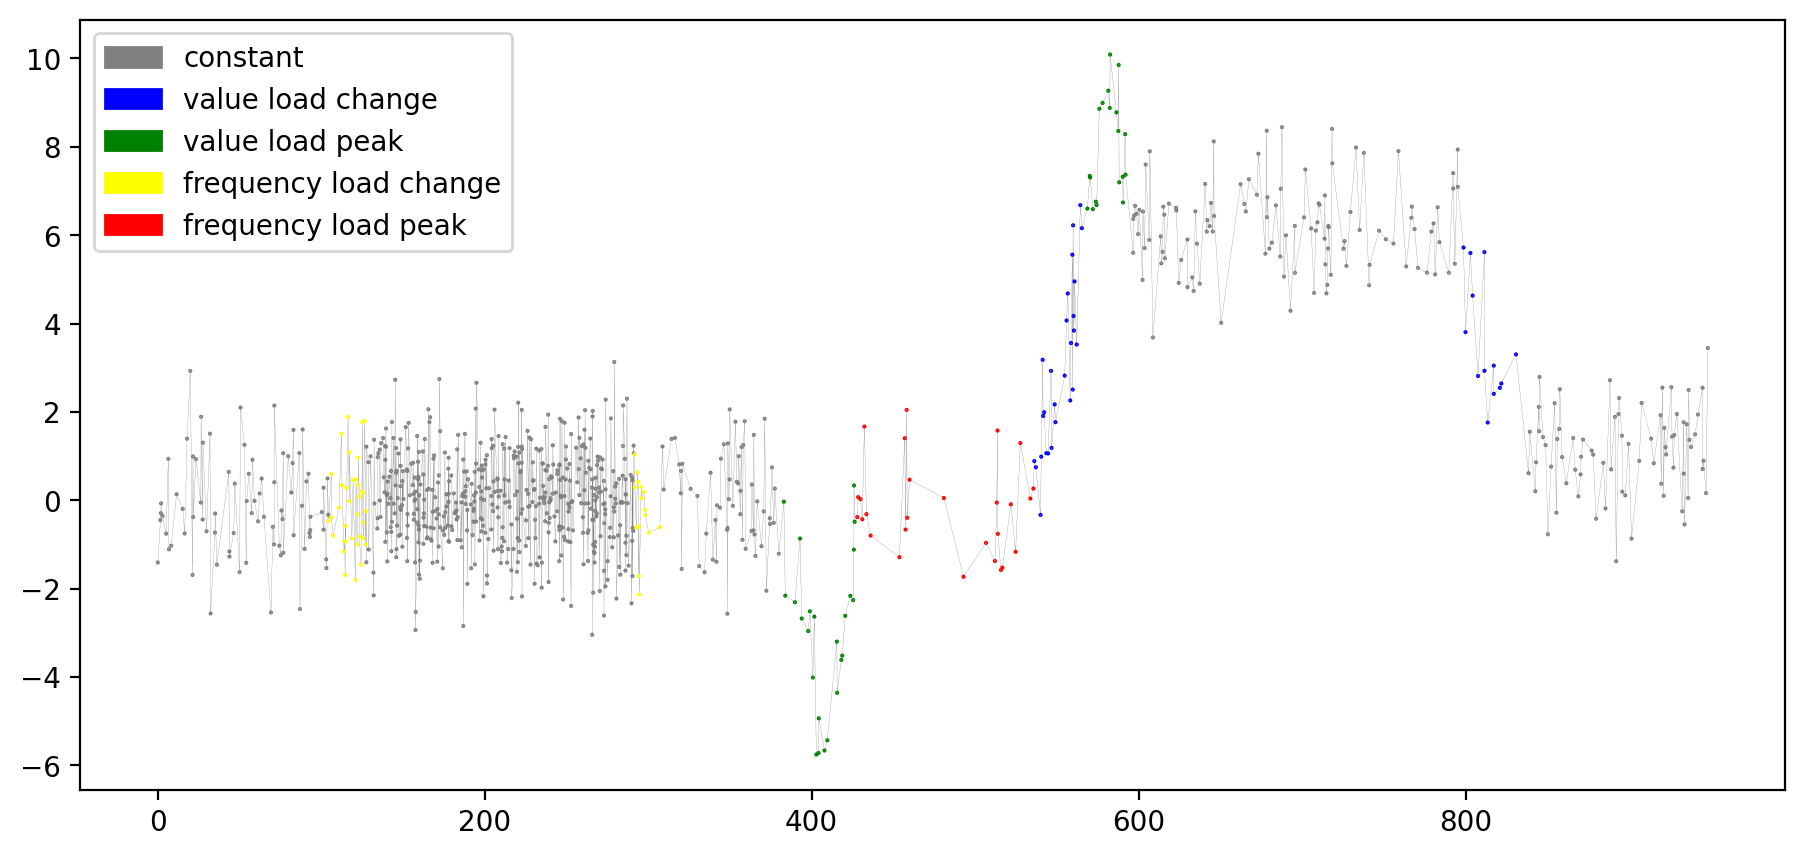

In [625]:
stream, signal = generate_stream(length=1000, episode_length=20)

labels = ['constant', 'value load change', 'value load peak',
               'frequency load change', 'frequency load peak']
colors = ['gray', 'blue', 'green', 'yellow', 'red']
plot_stream(stream, signal, labels=labels, colors=colors)

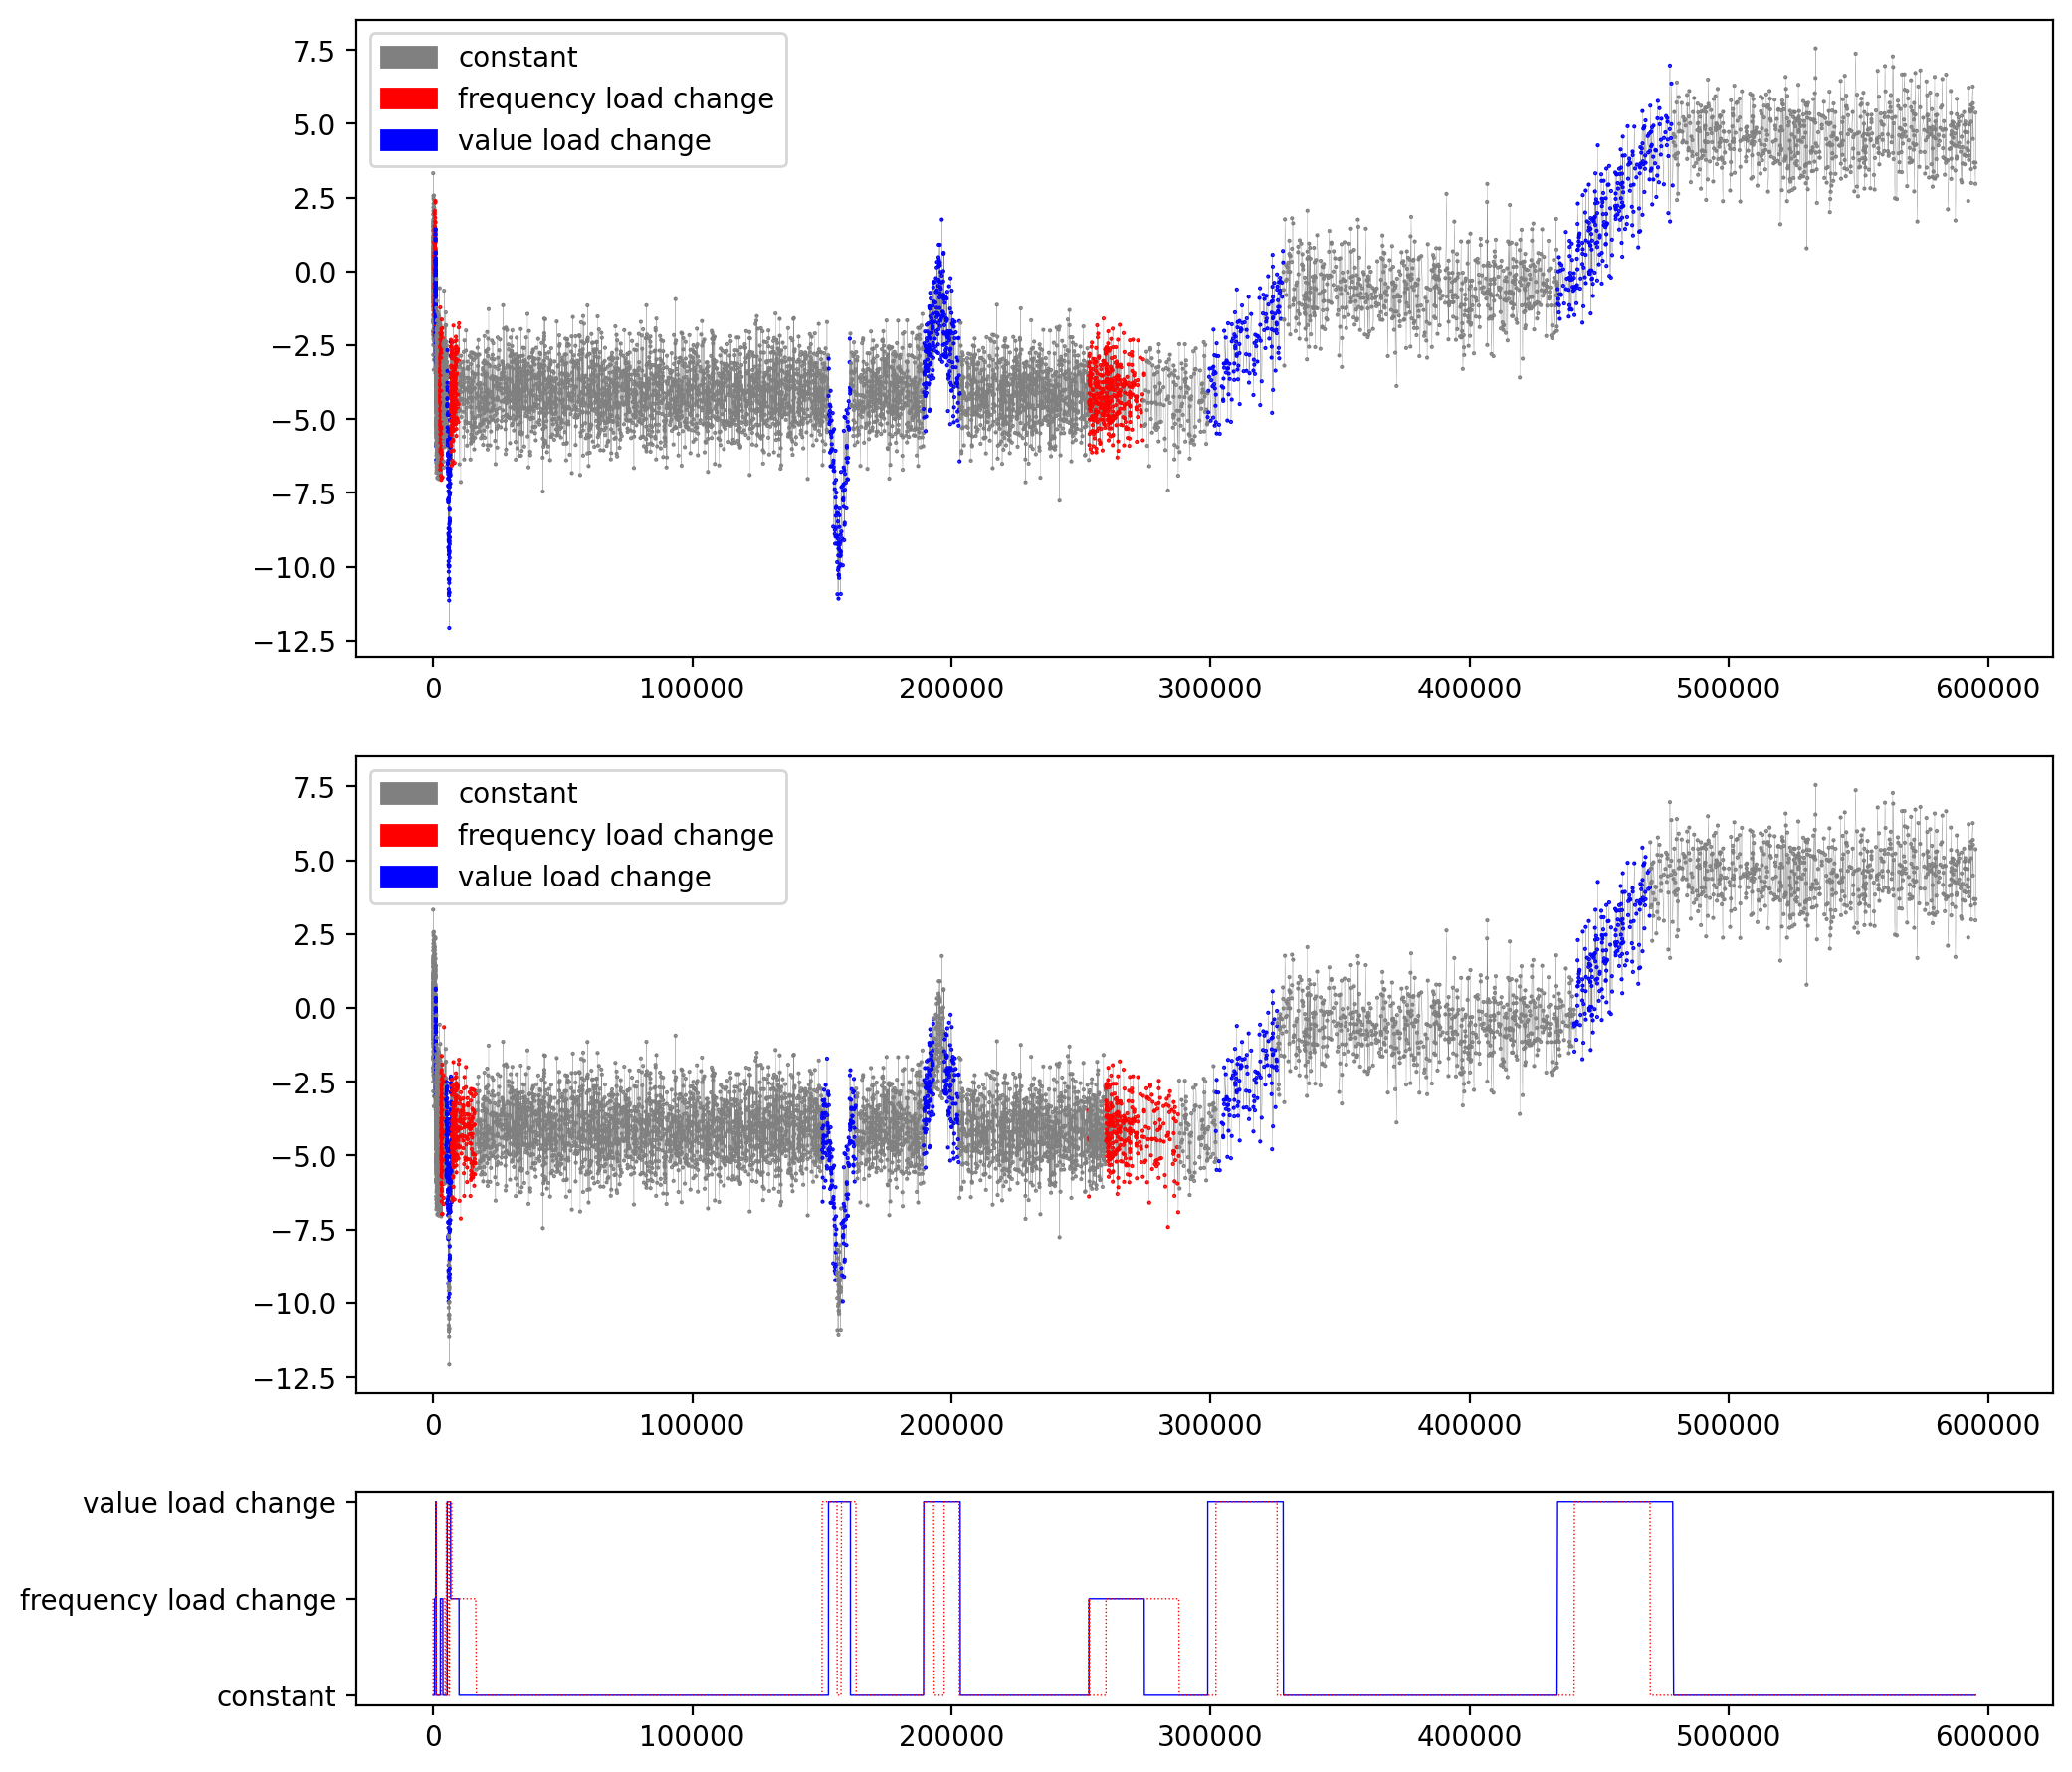

In [672]:
# Generate stream
stream, true_signal = generate_stream(length=10000, episode_length=200, abs_delta_mean=5, seed=3)
true_signal[true_signal == 1] = 2
true_signal[true_signal == 3] = 1
true_signal[true_signal == 4] = 1

# Detect changes
val_ws = 100
val_thres = 0.4
freq_ws = 200
freq_thres = 0.4

pred_signal = np.empty(stream.shape)
cd = DW_ChangeDetector(val_ws, val_thres, freq_ws, freq_thres)
for i, sample in enumerate(stream):
    pred_signal[i, :] = np.abs(cd.update(sample)) # we don't care about the direction of the change rn
pred_signal[:, 0] = np.concatenate((pred_signal[val_ws:, 0], np.zeros(val_ws)))
pred_signal[:, 1] = np.concatenate((pred_signal[freq_ws:, 1], np.zeros(freq_ws)))
pred_signal = np.max(pred_signal, 1)

# Plot evaluation
labels = ['constant', 'frequency load change', 'value load change']
colors = ['gray', 'red', 'blue']   
plot_comparison(stream, true_signal, pred_signal, labels=labels, colors=colors)

In [ ]:
######### LEGACY CODE #########

class PeakDetector:
    """
    Detect peaks in real time data streams. Uses the algorithm in the StackOverflow answer.
    """
    def __init__(self, lag=50, threshold=3, influence=0.5):
        self.lag = lag
        self.threshold = threshold
        self.influence = influence
        self.y = np.empty(lag)
        self.y.fill(np.nan)
        
    def update(self, sample):
        signal = self.__signal(sample)
        self.__update_y(sample, signal)
        return signal
    
    def __signal(self, sample):
        if self.y[0] == np.nan:
            return 0
        mean = np.mean(self.y)
        if np.abs(sample - mean) > self.threshold*np.std(self.y):
            if sample > mean:
                return 1
            else:
                return -1
        else:
            return 0
    
    def __update_y(self, sample, signal):
        if signal == 0:
            filtered_sample = sample
        else:
            filtered_sample = self.influence*sample + (1 - self.influence)*self.y[-1]
        self.y[:-1] = self.y[1:]
        self.y[-1] = filtered_sample
        
        
class EMA_ValueChangeDetector:
    """
    Detect changes in real time data streams. Measures difference between the two exponential 
    moving averages pilot and baseline.
    """
    def __init__(self, alpha=0.01, beta=0.05, threshold=1):
        self.alpha = alpha
        self.beta = beta
        self.threshold = threshold
        self.baseline = np.nan
        self.pilot = np.nan
        self.var = 100
        
    def update(self, sample):
        self.__update_stats(sample)
        signal = self.__signal()
        return signal
    
    def __signal(self):
        if abs(self.pilot - self.baseline) > self.threshold*np.sqrt(self.var):
            if self.pilot < self.baseline:
                return -1
            else:
                return 1
        else:
            return 0
    
    def __update_stats(self, sample):
        if np.isnan(self.baseline) or np.isnan(self.pilot):
            self.baseline = sample
            self.pilot = sample
        else:
            self.baseline = self.alpha*sample + (1 - self.alpha)*self.baseline
            self.pilot = self.beta*sample + (1 - self.beta)*self.pilot
            self.var = (1 - self.alpha)*(self.var + self.alpha*(sample - self.baseline)**2)

            
class EMA_FrequencyChangeDetector:
    """
    Detect changes in real time data streams. Measures difference between the two exponential 
    moving averages pilot and baseline.
    """
    def __init__(self, alpha=0.01, beta=0.05, threshold=1):
        self.alpha = alpha
        self.beta = beta
        self.threshold = threshold
        self.baseline = np.nan
        self.pilot = np.nan
        self.var = 100
        self.prev = 0
        
    def update(self, time):
        sample = time - self.prev
        self.prev = time
        self.__update_stats(sample)
        signal = self.__signal()
        return signal
    
    def __signal(self):
        if abs(self.pilot - self.baseline) > threshold*np.sqrt(self.var):
            if self.pilot < self.baseline:
                return -3
            else:
                return 3
        else:
            return 0
    
    def __update_stats(self, sample):
        if np.isnan(self.baseline) or np.isnan(self.pilot):
            self.baseline = sample
            self.pilot = sample
        else:
            self.baseline = self.alpha*sample + (1 - self.alpha)*self.baseline
            self.pilot = self.beta*sample + (1 - self.beta)*self.pilot
            self.var = (1 - self.alpha)*(self.var + self.alpha*(sample - self.baseline)**2)
            
            